$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
crimerate_data = pd.read_csv('USArrests.csv')

# Data Preparation
##  Normalize the features to make variables comparable

In [3]:
statesList = crimerate_data.iloc[:, 0].values # label 
data = crimerate_data.iloc[:, 1:5].values

In [4]:
data_scaled = preprocessing.scale(data)

# Perform the Hierarchical Clustering¶

In [5]:
# generate the linkage matrix ('average' method is selected)
linked = linkage(data_scaled, 'average')

## To check the [Cophenetic Correlation Coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation)

In [6]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linked, pdist(data_scaled))

### The closer the value is to 1, the better the clustering preserves the original distances

In [7]:
c

0.7180382379320472

# The Linkage Matrix
The linkage matrix is an array of length `n - 1`, where `n` is the number of our starting singleton clusters.  
`linked[i]` includes the information of which two clusters are merged at iteration `i` according the selected evalutation metric.  
For example: 

In [8]:
linked[0] 

array([14.       , 28.       ,  0.2079438,  2.       ])

The returned array is in the format of `[idx1, idx2, dist, sample_count]`. Therefore, at iteration `0`, since indices `14` and `28` only have a distance of `0.2079438`, they are merged together first.

In [9]:
linked[:10]

array([[14.        , 28.        ,  0.2079438 ,  2.        ],
       [12.        , 31.        ,  0.35377437,  2.        ],
       [13.        , 15.        ,  0.43312429,  2.        ],
       [22.        , 48.        ,  0.49909939,  2.        ],
       [35.        , 52.        ,  0.53043045,  3.        ],
       [19.        , 30.        ,  0.54082482,  2.        ],
       [18.        , 50.        ,  0.57847034,  3.        ],
       [36.        , 46.        ,  0.59956023,  2.        ],
       [45.        , 54.        ,  0.67765914,  4.        ],
       [40.        , 47.        ,  0.71809843,  2.        ]])

It can be noticed that `idx2` of `linked[4]` is `52`, but we only have `50` data points in total. Actually, all `idx >= 50` represents the cluster gererated in `linked[idx - 50]`. Therefore, for this case it just means to merge sample `35 (Oklahoma)` to our samples `13 (Indiana)` and `15 (Kansas)`. 

# Plotting a Dendrogram

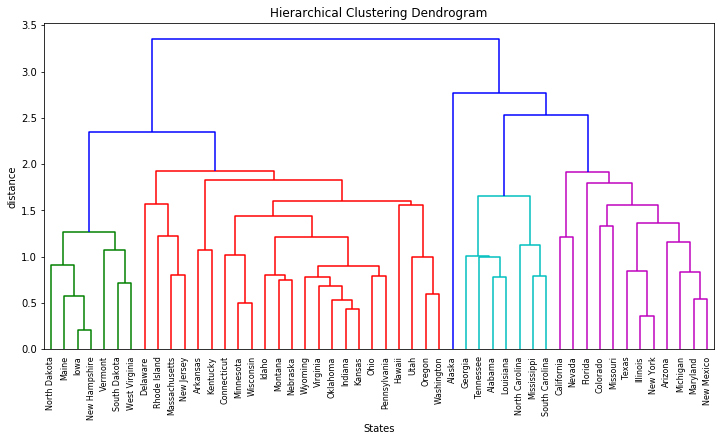

In [10]:
plt.figure(figsize=(12, 6)) 
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('States')
plt.ylabel('distance')
dendrogram(linked,
           orientation='top', #The direction to plot the dendrogram
                              #The root at the top, and descendent links going downwards
           labels=statesList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

# Determining the Number of Clusters

## Elbow Method
According to [wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering), the goal is to minimize the total intra-cluster variation:
$$
\arg\min_{\vec{S}}\sum_{i=1}^k\sum_{\vec{x}\in S_i}||\vec{x}-\mu_i||
$$
where we partition a set of observations $\vec{x} = (x_1, x_2, …, x_n)$ into k ($\leq n$) sets $\vec{S} = {S_1, S_2, …, S_k}$

clusters: 4


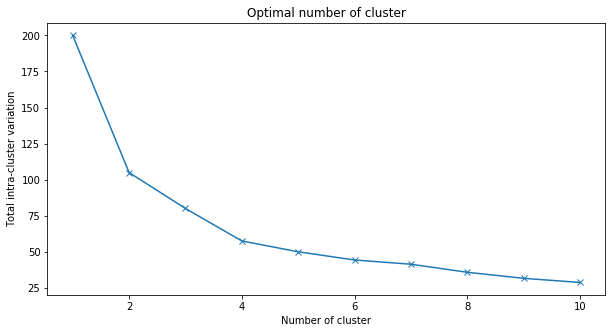

In [11]:
from sklearn.cluster import KMeans

cluster_range = range(1, 11)
wss = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit( data_scaled )
  wss.append( clusters.inertia_ )

plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster')
plt.ylabel('Total intra-cluster variation')
plt.plot(cluster_range, wss, marker = "x")

print("clusters:", 4)

Alternatively, we can just focus on finding where the acceleration of distance growth is the biggest:

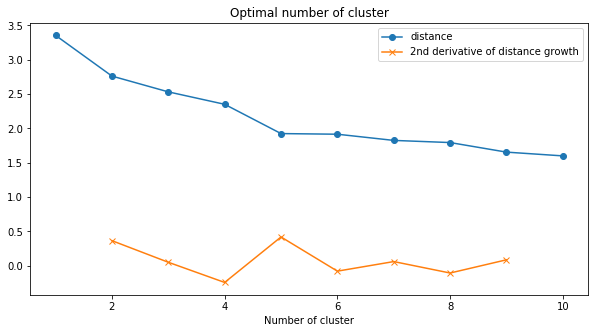

clusters: 5


In [12]:
last = linked[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)

plt.figure(figsize=(10,5))
plt.title('Optimal number of cluster')
plt.xlabel('Number of cluster')

plt.plot(idxs, last_rev, marker = "o", label="distance")

accele = np.diff(last, 2)  # 2nd derivative of the distances
accele_rev = accele[::-1]
plt.plot(idxs[:-2] + 1, accele_rev, marker = "x", label = "2nd derivative of distance growth")

plt.legend()
plt.show()
k = accele_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

# Plot Annotated Hierarchical Clustering Dendrograms
We can plot the annotated truncated dendrogram with cut-off line by using [fancy_dendrogram()](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)

In [13]:
# the following code is from
# [https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/]
def fancy_dendrogram(*args, **kwargs):
    plt.figure(figsize=(10,5))
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

## Four clusters

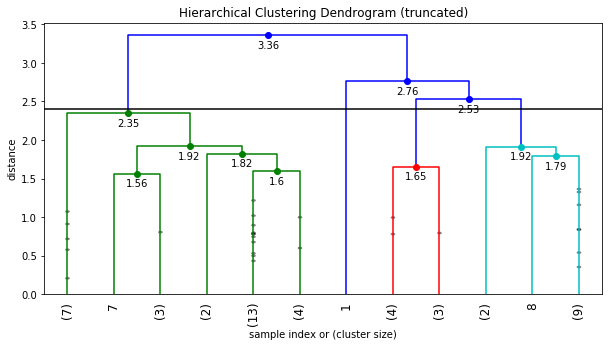

In [14]:
fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=2.4,  # a horizontal cut-off line
)

plt.show()

## Five clusters

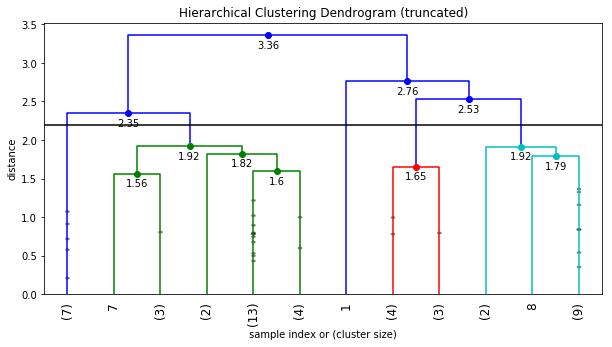

In [15]:
fancy_dendrogram(
    linked,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=1,
    max_d=2.2,  # a horizontal cut-off line
)

plt.show()